In [1]:
%load_ext memory_profiler

In [2]:
base_grid_kwargs = {
    "size_x": 1080, 
    "size_y": 1080, 
    "center_lon": -20, 
    "center_lat": 65, 
    "rot": 0, 
    "topography_source": {
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    }
}

In [3]:
grids = {
    "A": {"nx": 1080, "ny": 1080, "N": 100, **base_grid_kwargs},
    "B": {"nx": 2000, "ny": 2000, "N": 100, **base_grid_kwargs},  
    "C": {"nx": 2000, "ny": 2000, "N": 500, **base_grid_kwargs},   
}

# Performance

In [4]:
key = "A"

In [5]:
use_dask = True
bypass_validation = False

In [6]:
from roms_tools import Grid

We first create our grid object.

In [7]:
grid = Grid(**grids[key])

In [8]:
path = "/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/ERA5*.nc"
path = "/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/ERA5_2012-01.nc"
#path = "/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/ERA5_2012-01-02.nc"

In [9]:
from roms_tools import SurfaceForcing

In [10]:
from datetime import datetime

In [11]:
start_time = datetime(2012, 1, 1)
end_time = datetime(2012, 2, 29)

In [13]:
%%time
%%memit
# don't delete corr_factor

surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    correct_radiation=True,
    use_dask=use_dask,
    bypass_validation=bypass_validation
)

WARNING - No records found at or after the end_time.


peak memory: 13793.16 MiB, increment: 13248.64 MiB
CPU times: user 2min 2s, sys: 2.42 s, total: 2min 4s
Wall time: 15 s


In [14]:
%%time
%%memit
surface_forcing.ds.load()

peak memory: 83952.06 MiB, increment: 82957.21 MiB
CPU times: user 6h 38min 57s, sys: 1min 15s, total: 6h 40min 13s
Wall time: 3min 23s


In [12]:
%%time
%%memit

surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    correct_radiation=True,
    use_dask=use_dask,
    bypass_validation=bypass_validation
)

WARNING - No records found at or after the end_time.


peak memory: 13795.18 MiB, increment: 13217.93 MiB
CPU times: user 1min 58s, sys: 2.52 s, total: 2min 1s
Wall time: 14.9 s


In [14]:
%%time
%%memit
surface_forcing.ds.load()

peak memory: 78685.13 MiB, increment: 77731.97 MiB
CPU times: user 6h 46min 32s, sys: 1min 20s, total: 6h 47min 53s
Wall time: 3min 24s


In [12]:
%%time
%%memit

surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    correct_radiation=True,
    use_dask=use_dask,
    bypass_validation=bypass_validation
)

WARNING - No records found at or after the end_time.


peak memory: 34047.14 MiB, increment: 33496.71 MiB
CPU times: user 1min 58s, sys: 3.15 s, total: 2min 1s
Wall time: 9.54 s


In [13]:
surface_forcing.ds

<xarray.Dataset> Size: 24GB
Dimensions:   (time: 744, eta_rho: 1082, xi_rho: 1082)
Coordinates:
    abs_time  (time) datetime64[ns] 6kB 2012-01-01 ... 2012-01-31T23:00:00
  * time      (time) float64 6kB 4.383e+03 4.383e+03 ... 4.414e+03 4.414e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    swrad     (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    uwnd      (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 3GB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev177
    start_time:            2012-01-01 00:00:00
    end_time:              2012-02-29 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

In [14]:
from roms_tools.setup.utils import interpolate_from_climatology

In [15]:
from roms_tools.setup.datasets import ERA5Correction, ERA5Dataset

In [21]:
data = ERA5Dataset(filename=path, use_dask=use_dask, start_time=start_time, end_time=end_time)

WARNING - No records found at or after the end_time.


In [22]:
correction_data = ERA5Correction(use_dask=use_dask)

In [23]:
from roms_tools.regrid import LateralRegrid

In [24]:
        # choose same subdomain as forcing data so that we can use same mask
        coords_correction = {
            "lat": data.ds[data.dim_names["latitude"]],
            "lon": data.ds[data.dim_names["longitude"]],
        }
        correction_data.choose_subdomain(
            coords_correction, straddle=False
        )
        correction_data.ds["mask"] = data.ds["mask"]  # use mask from ERA5 data]
        correction_data.ds["time"] = correction_data.ds["time"].dt.days
        correction_data.apply_lateral_fill()
        # regrid
        lateral_regrid = LateralRegrid(surface_forcing.target_coords, data.dim_names)

        corr_factor = lateral_regrid.apply(
            correction_data.ds[correction_data.var_names["swr_corr"]]
        )

In [25]:
corr_factor

<xarray.DataArray 'ssr_corr' (time: 12, eta_rho: 1082, xi_rho: 1082)> Size: 112MB
dask.array<transpose, shape=(12, 1082, 1082), dtype=float64, chunksize=(1, 1082, 1082), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 96B 15 45 74 105 135 166 196 227 258 288 319 349
    lat_rho  (eta_rho, xi_rho) float64 9MB 59.77 59.77 59.77 ... 69.33 69.33
    lon_rho  (eta_rho, xi_rho) float64 9MB 330.3 330.4 330.4 ... 353.8 353.8
Dimensions without coordinates: eta_rho, xi_rho

In [26]:
import xarray as xr

In [22]:
%%time
%%memit
corr_factor_interpolated = xr.concat([
    interpolate_from_climatology(
        corr_factor,
        correction_data.dim_names["time"],
        time=time
    )
    for time in data.ds.time
], dim="time")

peak memory: 14423.25 MiB, increment: 13223.11 MiB
CPU times: user 10.5 s, sys: 2.06 s, total: 12.6 s
Wall time: 11.9 s


In [23]:
%%time
%%memit

corr_factor_interpolated.isel(time=0).compute()

peak memory: 1545.09 MiB, increment: 313.73 MiB
CPU times: user 49 s, sys: 922 ms, total: 49.9 s
Wall time: 926 ms


In [24]:
%%time
%%memit

corr_factor_interpolated.compute()

peak memory: 9063.37 MiB, increment: 7811.94 MiB
CPU times: user 35 s, sys: 1.88 s, total: 36.8 s
Wall time: 1.86 s


In [27]:
%%time
%%memit
corr_factor.persist()

peak memory: 2313.56 MiB, increment: 1170.70 MiB
CPU times: user 2min 6s, sys: 1.54 s, total: 2min 8s
Wall time: 1.58 s


In [28]:
%%time
%%memit
corr_factor_interpolated = xr.concat([
    interpolate_from_climatology(
        corr_factor,
        correction_data.dim_names["time"],
        time=time
    )
    for time in data.ds.time
], dim="time")

peak memory: 14748.25 MiB, increment: 13214.07 MiB
CPU times: user 9.41 s, sys: 2.2 s, total: 11.6 s
Wall time: 11.7 s


In [29]:
%%time
%%memit

corr_factor_interpolated.isel(time=0).compute()

peak memory: 1926.72 MiB, increment: 370.80 MiB
CPU times: user 48.3 s, sys: 800 ms, total: 49.1 s
Wall time: 988 ms


In [30]:
%%time
%%memit

corr_factor_interpolated.compute()

peak memory: 9065.88 MiB, increment: 7469.84 MiB
CPU times: user 1min 6s, sys: 2.89 s, total: 1min 9s
Wall time: 2.18 s


<xarray.DataArray 'ssr_corr' (time: 744, eta_rho: 1082, xi_rho: 1082)> Size: 7GB
dask.array<concatenate, shape=(744, 1082, 1082), dtype=float64, chunksize=(1, 1082, 1082), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float64 9MB 59.77 59.77 59.77 ... 69.33 69.33
    lon_rho  (eta_rho, xi_rho) float64 9MB 330.3 330.4 330.4 ... 353.8 353.8
  * time     (time) datetime64[ns] 6kB 2012-01-01 ... 2012-01-31T23:00:00
Dimensions without coordinates: eta_rho, xi_rho

In [30]:
print(f"Memory footprint: {corr_factor_interpolated.nbytes / 1e6:.2f} MB")

Memory footprint: 6968.15 MB


In [17]:
print(f"Memory footprint: {surface_forcing.ds.nbytes / 1e6:.2f} MB")

Memory footprint: 24388.53 MB


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

We can also plot any of the tidal forcing fields via the `.plot` method.

[########################################] | 100% Completed | 405.36 ms
peak memory: 1340.34 MiB, increment: 110.59 MiB
CPU times: user 15.9 s, sys: 663 ms, total: 16.6 s
Wall time: 1.49 s


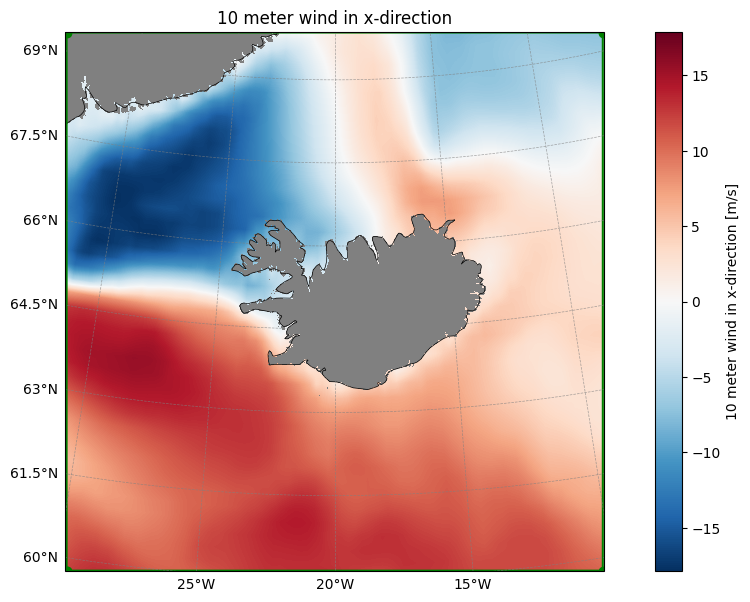

In [18]:
%%time
%%memit

surface_forcing.plot("uwnd")

## Saving as NetCDF or YAML file

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [19]:
filepath = "/pscratch/sd/n/nloose/forcing/my_surface_forcing.nc"

In [20]:
%%time
%%memit

surface_forcing.save(filepath)

[########################################] | 100% Completed | 401.42 s
peak memory: 99914.49 MiB, increment: 98635.34 MiB
CPU times: user 13h 40min 9s, sys: 4min 23s, total: 13h 44min 32s
Wall time: 7min 21s
